# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

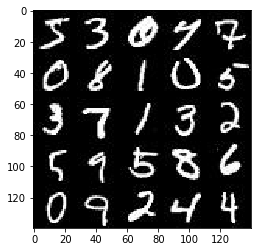

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

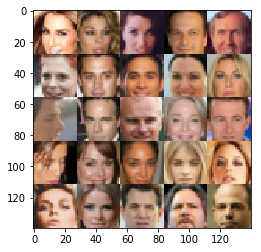

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_r = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_r') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32,name='lr')
    return inputs_r, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 32, 5, 2, 'same')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        #print(lrelu1.shape)
        
        conv2 = tf.layers.conv2d(lrelu1, 64, 5, 2, 'same')
        batch_norm1 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm1, batch_norm1)
        #print(lrelu2.shape)
        
        conv3 = tf.layers.conv2d(lrelu2, 128, 5, 2, 'same')
        batch_norm2 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm2, batch_norm2)
        #print(lrelu3.shape)    
       
        flat = tf.reshape(lrelu3, (-1, 4*4*128))
        
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    reuse=not is_train
    with tf.variable_scope('generator', reuse=reuse):


        fc1 = tf.layers.dense(z, 7*7*128)
        reshape = tf.reshape(fc1, (-1, 7, 7, 128))
        batch_norm1 = tf.layers.batch_normalization(reshape, training=is_train)
        lrelu1 = tf.maximum(alpha * batch_norm1, batch_norm1)
        #print(lrelu1.shape)
        
        deconv1 = tf.layers.conv2d_transpose(lrelu1, 64, 5, 2, 'same')
        batch_norm2 = tf.layers.batch_normalization(deconv1, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        #print(lrelu2.shape)        
        
        deconv2 = tf.layers.conv2d_transpose(lrelu2, 32, 5, 2, 'same')
        batch_norm3 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        #print(lrelu3.shape)

        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 3, 1, 'same')
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import datetime

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    count, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    steps_count=count//batch_size
    start_time = datetime.datetime.now()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    end_time = datetime.datetime.now()
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps {}/{}...".format(steps, steps_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g),
                          "Time: {}".format(end_time-start_time))
                    start_time = datetime.datetime.now()

                if steps % 500 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
            show_generator_output(sess, 16, input_z, image_channels, data_image_mode)           
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Steps 50/937... Discriminator Loss: 1.7256... Generator Loss: 0.4581... Time: 0:00:07.052819
Epoch 1/2... Steps 100/937... Discriminator Loss: 1.1853... Generator Loss: 0.9255... Time: 0:00:04.419618
Epoch 1/2... Steps 150/937... Discriminator Loss: 1.3314... Generator Loss: 0.7321... Time: 0:00:04.408035
Epoch 1/2... Steps 200/937... Discriminator Loss: 1.0480... Generator Loss: 2.0632... Time: 0:00:04.401286
Epoch 1/2... Steps 250/937... Discriminator Loss: 0.9620... Generator Loss: 1.2279... Time: 0:00:04.423032
Epoch 1/2... Steps 300/937... Discriminator Loss: 1.1550... Generator Loss: 1.4054... Time: 0:00:04.374652
Epoch 1/2... Steps 350/937... Discriminator Loss: 0.9301... Generator Loss: 1.2407... Time: 0:00:04.366537
Epoch 1/2... Steps 400/937... Discriminator Loss: 1.9078... Generator Loss: 0.2737... Time: 0:00:04.430414
Epoch 1/2... Steps 450/937... Discriminator Loss: 1.0675... Generator Loss: 1.2213... Time: 0:00:04.358494
Epoch 1/2... Steps 500/937... Discrimi

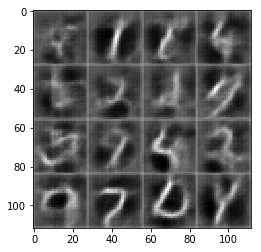

Epoch 1/2... Steps 550/937... Discriminator Loss: 1.2097... Generator Loss: 1.1363... Time: 0:00:04.921767
Epoch 1/2... Steps 600/937... Discriminator Loss: 1.1738... Generator Loss: 1.1070... Time: 0:00:04.425015
Epoch 1/2... Steps 650/937... Discriminator Loss: 1.2868... Generator Loss: 0.6710... Time: 0:00:04.399659
Epoch 1/2... Steps 700/937... Discriminator Loss: 1.3033... Generator Loss: 0.6326... Time: 0:00:04.386656
Epoch 1/2... Steps 750/937... Discriminator Loss: 1.0859... Generator Loss: 1.1873... Time: 0:00:04.412170
Epoch 1/2... Steps 800/937... Discriminator Loss: 1.1343... Generator Loss: 0.7733... Time: 0:00:04.428729
Epoch 1/2... Steps 850/937... Discriminator Loss: 1.2554... Generator Loss: 1.4532... Time: 0:00:04.446523
Epoch 1/2... Steps 900/937... Discriminator Loss: 1.0864... Generator Loss: 1.3705... Time: 0:00:04.406416


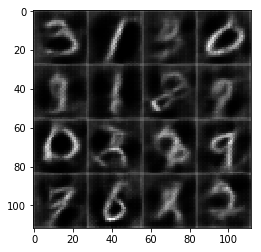

Epoch 2/2... Steps 50/937... Discriminator Loss: 1.0932... Generator Loss: 0.8557... Time: 0:00:08.157445
Epoch 2/2... Steps 100/937... Discriminator Loss: 1.1129... Generator Loss: 0.8857... Time: 0:00:04.410819
Epoch 2/2... Steps 150/937... Discriminator Loss: 1.2595... Generator Loss: 0.7272... Time: 0:00:04.458097
Epoch 2/2... Steps 200/937... Discriminator Loss: 1.0613... Generator Loss: 0.8349... Time: 0:00:04.393713
Epoch 2/2... Steps 250/937... Discriminator Loss: 0.9243... Generator Loss: 1.0076... Time: 0:00:04.432980
Epoch 2/2... Steps 300/937... Discriminator Loss: 1.0332... Generator Loss: 1.1302... Time: 0:00:04.404093
Epoch 2/2... Steps 350/937... Discriminator Loss: 0.9278... Generator Loss: 1.0838... Time: 0:00:04.404470
Epoch 2/2... Steps 400/937... Discriminator Loss: 1.0589... Generator Loss: 0.9246... Time: 0:00:04.417663
Epoch 2/2... Steps 450/937... Discriminator Loss: 0.9082... Generator Loss: 1.6264... Time: 0:00:04.449860
Epoch 2/2... Steps 500/937... Discrimi

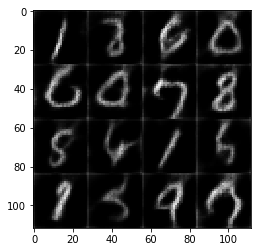

Epoch 2/2... Steps 550/937... Discriminator Loss: 1.1524... Generator Loss: 0.7498... Time: 0:00:04.918017
Epoch 2/2... Steps 600/937... Discriminator Loss: 0.9461... Generator Loss: 1.0763... Time: 0:00:04.403241
Epoch 2/2... Steps 650/937... Discriminator Loss: 1.0790... Generator Loss: 0.9301... Time: 0:00:04.392604
Epoch 2/2... Steps 700/937... Discriminator Loss: 0.8409... Generator Loss: 1.4992... Time: 0:00:04.409257
Epoch 2/2... Steps 750/937... Discriminator Loss: 1.7547... Generator Loss: 0.4505... Time: 0:00:04.388755
Epoch 2/2... Steps 800/937... Discriminator Loss: 1.0520... Generator Loss: 0.8743... Time: 0:00:04.420730
Epoch 2/2... Steps 850/937... Discriminator Loss: 0.6729... Generator Loss: 2.0244... Time: 0:00:04.478889
Epoch 2/2... Steps 900/937... Discriminator Loss: 0.9253... Generator Loss: 1.3863... Time: 0:00:04.444974


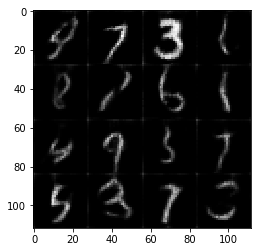

In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Steps 50/3165... Discriminator Loss: 1.6152... Generator Loss: 0.4259... Time: 0:00:10.490582
Epoch 1/1... Steps 100/3165... Discriminator Loss: 1.0578... Generator Loss: 1.1881... Time: 0:00:08.320708
Epoch 1/1... Steps 150/3165... Discriminator Loss: 1.4340... Generator Loss: 0.6762... Time: 0:00:08.285825
Epoch 1/1... Steps 200/3165... Discriminator Loss: 1.1574... Generator Loss: 1.1170... Time: 0:00:08.282016
Epoch 1/1... Steps 250/3165... Discriminator Loss: 1.3070... Generator Loss: 0.7366... Time: 0:00:08.293205
Epoch 1/1... Steps 300/3165... Discriminator Loss: 1.2773... Generator Loss: 1.2628... Time: 0:00:08.395936
Epoch 1/1... Steps 350/3165... Discriminator Loss: 1.3089... Generator Loss: 1.0554... Time: 0:00:08.355805
Epoch 1/1... Steps 400/3165... Discriminator Loss: 1.4750... Generator Loss: 0.6503... Time: 0:00:08.402801
Epoch 1/1... Steps 450/3165... Discriminator Loss: 1.4040... Generator Loss: 0.9173... Time: 0:00:08.135765
Epoch 1/1... Steps 500/3165..

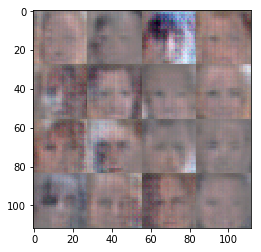

Epoch 1/1... Steps 550/3165... Discriminator Loss: 1.3231... Generator Loss: 0.6398... Time: 0:00:08.805144
Epoch 1/1... Steps 600/3165... Discriminator Loss: 1.1855... Generator Loss: 0.7582... Time: 0:00:08.436665
Epoch 1/1... Steps 650/3165... Discriminator Loss: 1.3076... Generator Loss: 0.6789... Time: 0:00:08.351197
Epoch 1/1... Steps 700/3165... Discriminator Loss: 1.4500... Generator Loss: 0.6533... Time: 0:00:08.383918
Epoch 1/1... Steps 750/3165... Discriminator Loss: 1.2017... Generator Loss: 1.0349... Time: 0:00:08.331378
Epoch 1/1... Steps 800/3165... Discriminator Loss: 1.3239... Generator Loss: 0.8212... Time: 0:00:08.463729
Epoch 1/1... Steps 850/3165... Discriminator Loss: 1.2276... Generator Loss: 0.8592... Time: 0:00:08.478620
Epoch 1/1... Steps 900/3165... Discriminator Loss: 1.4301... Generator Loss: 0.6336... Time: 0:00:08.302916
Epoch 1/1... Steps 950/3165... Discriminator Loss: 1.3634... Generator Loss: 0.7612... Time: 0:00:08.388909
Epoch 1/1... Steps 1000/3165

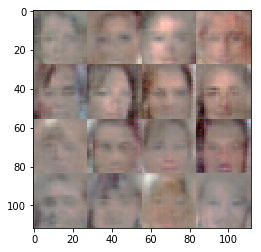

Epoch 1/1... Steps 1050/3165... Discriminator Loss: 1.2132... Generator Loss: 0.8089... Time: 0:00:09.153861
Epoch 1/1... Steps 1100/3165... Discriminator Loss: 1.4142... Generator Loss: 0.6654... Time: 0:00:08.398278
Epoch 1/1... Steps 1150/3165... Discriminator Loss: 1.4104... Generator Loss: 0.7806... Time: 0:00:08.339567
Epoch 1/1... Steps 1200/3165... Discriminator Loss: 1.4874... Generator Loss: 0.7378... Time: 0:00:08.421710
Epoch 1/1... Steps 1250/3165... Discriminator Loss: 1.4101... Generator Loss: 0.6313... Time: 0:00:08.365744
Epoch 1/1... Steps 1300/3165... Discriminator Loss: 1.2879... Generator Loss: 0.7870... Time: 0:00:08.275971
Epoch 1/1... Steps 1350/3165... Discriminator Loss: 1.5799... Generator Loss: 0.4911... Time: 0:00:08.209716
Epoch 1/1... Steps 1400/3165... Discriminator Loss: 1.1716... Generator Loss: 1.0466... Time: 0:00:08.116512
Epoch 1/1... Steps 1450/3165... Discriminator Loss: 1.3848... Generator Loss: 0.7744... Time: 0:00:08.213720
Epoch 1/1... Steps 

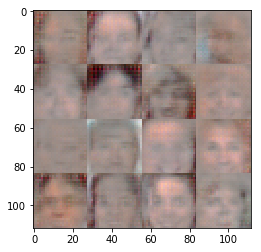

Epoch 1/1... Steps 1550/3165... Discriminator Loss: 1.3326... Generator Loss: 0.7546... Time: 0:00:08.839481
Epoch 1/1... Steps 1600/3165... Discriminator Loss: 1.3051... Generator Loss: 0.8847... Time: 0:00:08.370999
Epoch 1/1... Steps 1650/3165... Discriminator Loss: 1.3178... Generator Loss: 0.6676... Time: 0:00:08.284154
Epoch 1/1... Steps 1700/3165... Discriminator Loss: 1.2164... Generator Loss: 0.8738... Time: 0:00:08.065282
Epoch 1/1... Steps 1750/3165... Discriminator Loss: 1.3709... Generator Loss: 0.8713... Time: 0:00:08.006505
Epoch 1/1... Steps 1800/3165... Discriminator Loss: 1.3161... Generator Loss: 0.6677... Time: 0:00:08.051393
Epoch 1/1... Steps 1850/3165... Discriminator Loss: 1.3493... Generator Loss: 0.8869... Time: 0:00:08.091075
Epoch 1/1... Steps 1900/3165... Discriminator Loss: 1.4054... Generator Loss: 0.9966... Time: 0:00:07.913215
Epoch 1/1... Steps 1950/3165... Discriminator Loss: 1.2867... Generator Loss: 0.9001... Time: 0:00:08.021228
Epoch 1/1... Steps 

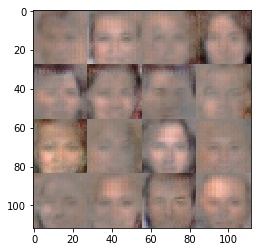

Epoch 1/1... Steps 2050/3165... Discriminator Loss: 1.3426... Generator Loss: 0.9176... Time: 0:00:08.673710
Epoch 1/1... Steps 2100/3165... Discriminator Loss: 1.3273... Generator Loss: 0.6304... Time: 0:00:08.096715
Epoch 1/1... Steps 2150/3165... Discriminator Loss: 1.2045... Generator Loss: 0.9757... Time: 0:00:07.904041
Epoch 1/1... Steps 2200/3165... Discriminator Loss: 1.2640... Generator Loss: 0.7184... Time: 0:00:07.992184
Epoch 1/1... Steps 2250/3165... Discriminator Loss: 1.3646... Generator Loss: 0.6961... Time: 0:00:07.895595
Epoch 1/1... Steps 2300/3165... Discriminator Loss: 1.2565... Generator Loss: 1.1179... Time: 0:00:07.972946
Epoch 1/1... Steps 2350/3165... Discriminator Loss: 1.2656... Generator Loss: 0.8197... Time: 0:00:07.928333
Epoch 1/1... Steps 2400/3165... Discriminator Loss: 1.2195... Generator Loss: 0.8257... Time: 0:00:07.764639
Epoch 1/1... Steps 2450/3165... Discriminator Loss: 1.2738... Generator Loss: 0.8401... Time: 0:00:07.814527
Epoch 1/1... Steps 

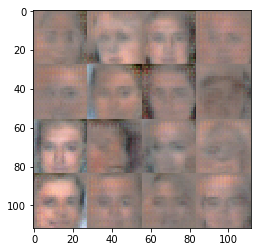

Epoch 1/1... Steps 2550/3165... Discriminator Loss: 1.5521... Generator Loss: 0.5184... Time: 0:00:08.600119
Epoch 1/1... Steps 2600/3165... Discriminator Loss: 1.4922... Generator Loss: 0.5200... Time: 0:00:07.911432
Epoch 1/1... Steps 2650/3165... Discriminator Loss: 1.3266... Generator Loss: 0.7803... Time: 0:00:07.787629
Epoch 1/1... Steps 2700/3165... Discriminator Loss: 1.3703... Generator Loss: 0.6999... Time: 0:00:07.647243
Epoch 1/1... Steps 2750/3165... Discriminator Loss: 1.2858... Generator Loss: 0.7044... Time: 0:00:07.821135
Epoch 1/1... Steps 2800/3165... Discriminator Loss: 1.2659... Generator Loss: 0.7306... Time: 0:00:07.759444
Epoch 1/1... Steps 2850/3165... Discriminator Loss: 1.3991... Generator Loss: 1.2823... Time: 0:00:07.608572
Epoch 1/1... Steps 2900/3165... Discriminator Loss: 1.3908... Generator Loss: 0.9809... Time: 0:00:07.641452
Epoch 1/1... Steps 2950/3165... Discriminator Loss: 1.3466... Generator Loss: 0.6790... Time: 0:00:07.540002
Epoch 1/1... Steps 

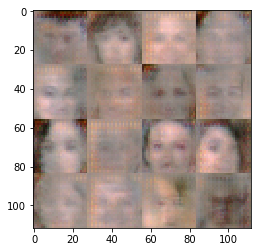

Epoch 1/1... Steps 3050/3165... Discriminator Loss: 1.2742... Generator Loss: 0.6697... Time: 0:00:08.719611
Epoch 1/1... Steps 3100/3165... Discriminator Loss: 1.3361... Generator Loss: 0.6242... Time: 0:00:07.776178
Epoch 1/1... Steps 3150/3165... Discriminator Loss: 1.3063... Generator Loss: 0.8170... Time: 0:00:07.800427


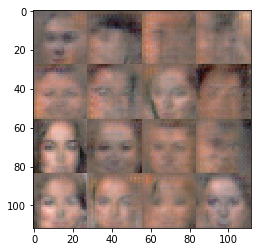

In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)    

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.